In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

In [52]:
class bot:
    '''API for two wheel differential drive bot (numpy required)'''

    #Note:- SI units for everything, same for all bots
    d = 0.05                    #distance between axle / 2
    w = 1.0                     #max angular vel of wheels
    wheel_radius = 0.03
    s_max = w * wheel_radius    #max speed of bot in forward dir
    
    def __init__(self, x=0.0, y=0.0, L=0.0, R=0.0, dir = 0):
        self.pos = np.array([x,y], dtype=float)
        self.R = R              #Normalized
        self.L = L              #Normalized
        self.dir = dir          #In Radians

    @property
    def x(self) -> float:
        return self.pos[0]
    @x.setter
    def x(self, x: float):
        self.pos[0] = x
    
    @property
    def y(self) -> float:
        return self.pos[1]
    @y.setter
    def y(self, y: float):
        self.pos[1] = y
    
    @property
    def tangent(self):
        return np.array([np.cos(self.dir), np.sin(self.dir)], dtype=float)
    @tangent.setter
    def tangent(self, v):
        self.dir = np.arctan2(v[1], v[0])

    @classmethod
    def ratioTOr(cls, ratio: float) -> float:
        if ratio == 1:
            return float('inf')
        else:
            return cls.d * (1+ratio)/(1-ratio)
    
    @classmethod
    def rTOratio(cls, r: float) -> float:
        return (r-cls.d)/(r+cls.d)

    def ratio(self) -> float:
        return self.R / self.L
    
    def set_ratio(self, ratio: float, sign=1):
        '''Sets optimal R and L'''
        if abs(ratio)>1:
            self.R = 1.0
            self.L = 1/ratio
        else:
            self.L = 1.0
            self.R = ratio
        self.R *= sign
        self.L *= sign
    
    def path_radius(self) -> float:
        return self.ratioTOr(self.ratio())

    def update(self, t: float):
        '''runs bot with given L and R in direction dir for t seconds'''
        if self.ratio()==1:
            self.pos += self.tangent * self.speed() * t
        else:
            r = self.path_radius()
            phi = self.speed() * t/r
            a, b = r * np.sin(phi) * np.array([1,-np.tan(phi)])
            self.pos += (a * np.cos(self.dir) - b * np.sin(self.dir), b * np.cos(self.dir) + a * np.sin(self.dir)) 
            self.dir -= phi
        return self.pos
    
    def dupdate(self, dt: float):
        '''Same as update, for small change dt'''
        if self.ratio()==1:
            self.pos += self.tangent * self.speed() * dt
        else:
            r = self.path_radius()
            dist = self.speed() * dt
            a,b = dist * np.array([1, -dist/r])
            self.pos += (a * np.cos(self.dir) - b * np.sin(self.dir), b * np.cos(self.dir) + a * np.sin(self.dir)) 
            self.dir -= dist/r
        return self.pos
    
    def dest_point(self, final) -> float:
        '''Sets (optimal) L and R for given desination point
        Returns time required to reach the point'''
        tang = self.tangent
        perp = np.array((tang[1], -tang[0]))
        M = (final - self.pos)/2 #midpoint
        P = np.dot(M, perp)
        T = np.dot(M, tang)
        if P == 0:
            ratio = 1.0
            dist = 2*T
        else:
            r = P + (T*T)/P
            ratio = self.rTOratio(r)
            theta = np.arctan2(2*T, 2*P-r)
            if r > 0:
                dist = r * (np.pi - theta)
            else:
                dist = abs(r) * (theta)
        self.set_ratio(ratio)

        return dist/self.speed()

    def speed(self) -> float:
        return self.s_max * (self.R + self.L)/2
    
    def velocity(self):
        return self.speed() * self.tangent

    def __str__(self) -> str:
        return f"({self.x}, {self.y}) at {self.speed()} m/s in {self.dir} rad"

(0.0, 0.0) at 0.02964426877470356 m/s in 1.5707963267948966 rad
1.0 0.9762845849802373 180.8953116941121
(3.087234194143292, 3.9374522117433077) at 0.02964426877470356 m/s in 0.2837941092083358 rad


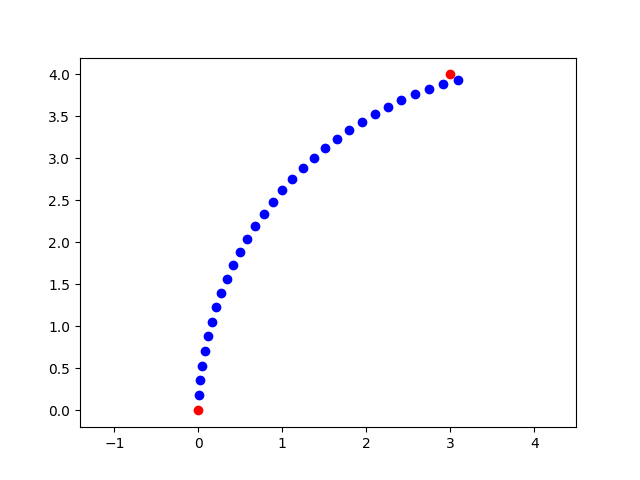

In [66]:
#example
b=bot(0,0,dir = np.pi/2)
fig, ax = plt.subplots()
ax.axis('equal')

t = b.dest_point((3,4))
print(b)
print(b.L, b.R, t)
ax.scatter(b.x, b.y, c= 'r')
ax.scatter(3,4, c='r')
n=30
for _ in range(n):
    b.update(t/n)
    ax.scatter(b.x, b.y, c='b')
print(b)
plt.show()